In [1]:
!nvidia-smi

Fri Dec  8 10:16:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.91       Driver Version: 516.91       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    11W /  N/A |   1044MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Preprocessing

In [2]:
#Imports
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
#Import data
metadata = pd.read_csv('./application_metadata.csv')

In [4]:
metadata['status'].value_counts()

status
ISS     3139764
ABN      977521
PEND     798795
Name: count, dtype: int64

In [5]:
#Removing pending patents
metadata = metadata[metadata['status'] != 'PEND']

In [6]:
metadata['status'].value_counts()

status
ISS    3139764
ABN     977521
Name: count, dtype: int64

In [7]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4117285 entries, 0 to 4915887
Data columns (total 8 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   doc-id                    int64  
 1   examiner_experience       int64  
 2   examiner_allowance_ratio  float64
 3   class_saturation          int64  
 4   subclass_saturation       int64  
 5   customer_experience       int64  
 6   customer_success_ratio    float64
 7   status                    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 282.7+ MB


In [8]:
metadata.describe()

,doc-id,examiner_experience,examiner_allowance_ratio,class_saturation,subclass_saturation,customer_experience,customer_success_ratio
count,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06
mean,1.234501e+07,5.029763e+02,7.643155e-01,1.675307e+04,2.954730e+03,5.029763e+02,7.643155e-01
std,5.607356e+06,1.320641e+03,2.228962e-01,2.099201e+04,3.829545e+03,1.320641e+03,2.228962e-01
min,2.618355e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.010214e+07,1.030000e+02,6.315789e-01,2.936000e+03,4.590000e+02,1.030000e+02,6.315789e-01
50%,1.140475e+07,2.630000e+02,8.390142e-01,8.520000e+03,1.750000e+03,2.630000e+02,8.390142e-01
75%,1.262732e+07,5.720000e+02,9.437908e-01,2.127600e+04,4.032000e+03,5.720000e+02,9.437908e-01
max,9.603000e+07,2.694000e+04,1.000000e+00,1.255260e+05,3.846600e+04,2.694000e+04,1.000000e+00


In [9]:
#Data seems to be skewed by earlier results. Taking only last ~1,000,000
metadata = metadata[3000000:]

In [10]:
#Encoding target feature
metadata['status'] = metadata['status'].replace({'ISS': 1, 'ABN': 0})
metadata['status'].value_counts()

status
1    844069
0    273216
Name: count, dtype: int64

In [13]:
#Splitting into train and test (not shuffling to keep data sequential)
from sklearn.model_selection import train_test_split

X = metadata.drop(['status', 'doc-id'], axis=1)
y = metadata['status']

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle = False)

In [14]:
len(X_train), len(X_val), len(X_test)

(893828, 111728, 111729)

In [15]:
#Scaling data using Standard Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val), columns = X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


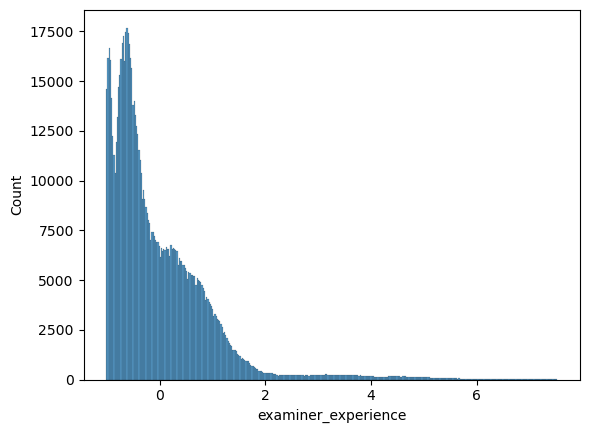

C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


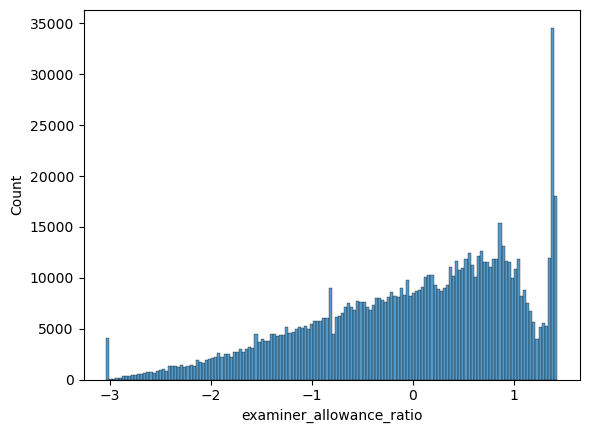

C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


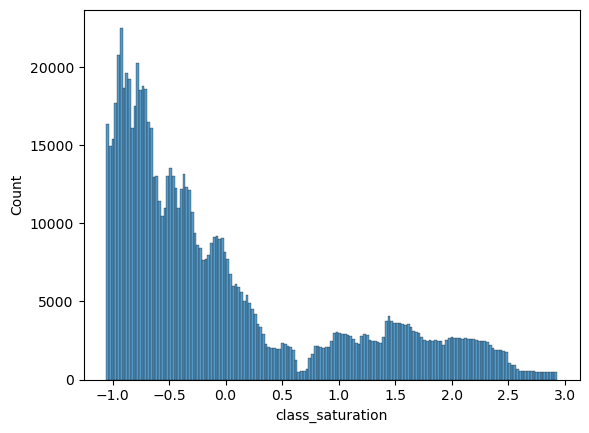

C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


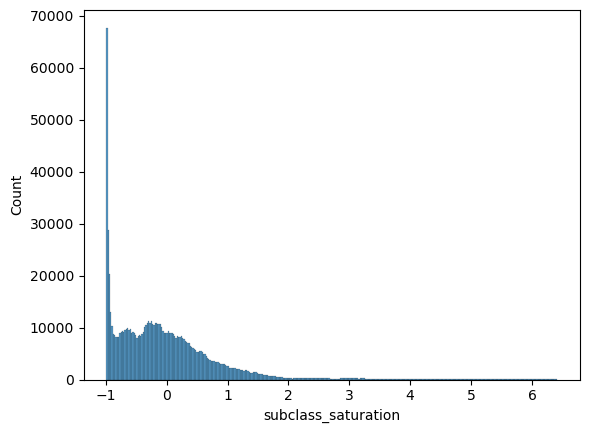

C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


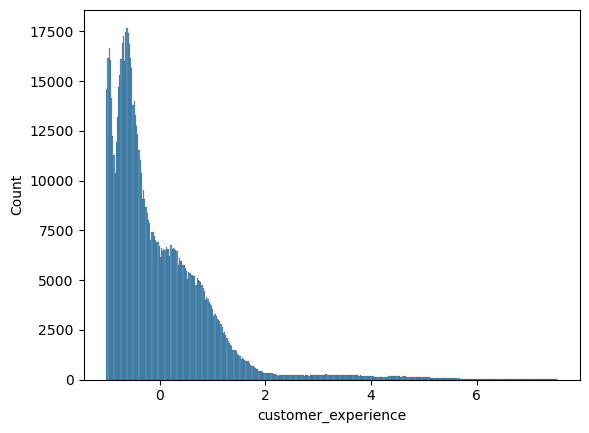

C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\4esha\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


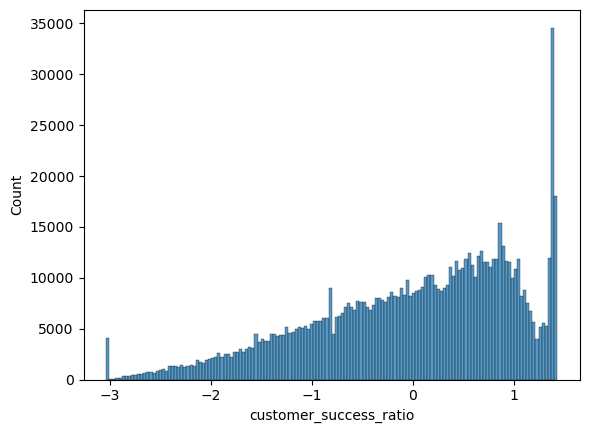

In [16]:
#Plotting distributions for relevant features in training set after scaling
for feature in ['examiner_experience', 'examiner_allowance_ratio', 'class_saturation', 'subclass_saturation', 'customer_experience', 'customer_success_ratio']:
  sns.histplot(X_train[feature])
  plt.show()

In [17]:
X_train.describe()

,examiner_experience,examiner_allowance_ratio,class_saturation,subclass_saturation,customer_experience,customer_success_ratio
count,8.938280e+05,8.938280e+05,8.938280e+05,8.938280e+05,8.938280e+05,8.938280e+05
mean,-6.707733e-17,3.693307e-16,5.043121e-17,3.680588e-17,-6.707733e-17,3.693307e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.014396e+00,-3.038604e+00,-1.056936e+00,-9.940641e-01,-1.014396e+00,-3.038604e+00
25%,-6.667279e-01,-6.704843e-01,-7.615958e-01,-6.823690e-01,-6.667279e-01,-6.704843e-01
50%,-3.060630e-01,1.696502e-01,-3.698908e-01,-1.864905e-01,-3.060630e-01,1.696502e-01
75%,4.201407e-01,8.056560e-01,4.077194e-01,3.529337e-01,4.201407e-01,8.056560e-01
max,7.524590e+00,1.432253e+00,2.932759e+00,6.412445e+00,7.524590e+00,1.432253e+00


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [19]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
X_train

,examiner_experience,examiner_allowance_ratio,class_saturation,subclass_saturation,customer_experience,customer_success_ratio
0,-0.780451,0.252444,-0.815020,-0.134819,-0.780451,0.252444
1,0.259304,0.360160,1.407541,-0.950935,0.259304,0.360160
2,-0.587122,-0.471686,-0.784014,0.829852,-0.587122,-0.471686
3,-0.669977,-0.529019,0.933413,-0.479017,-0.669977,-0.529019
4,-0.747959,0.123710,-0.873166,4.284751,-0.747959,0.123710
...,...,...,...,...,...,...
893823,-0.294691,-1.222003,-0.949529,-0.769252,-0.294691,-1.222003
893824,0.114713,0.930488,-0.780705,0.247507,0.114713,0.930488
893825,1.729582,0.746669,0.000214,-0.593819,1.729582,0.746669
893826,-0.239454,0.279391,-0.672741,6.412445,-0.239454,0.279391


In [21]:
# Convert to PyTorch tensors
X_train_tensors = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
X_val_tensors = torch.tensor(X_val.to_numpy(), dtype=torch.float32).to(device)
X_test_tensors = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)

y_train_tensors = torch.tensor(y_train.to_numpy(), dtype=torch.float32).to(device)
y_val_tensors = torch.tensor(y_val.to_numpy(), dtype=torch.float32).to(device)
y_test_tensors = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [25]:
train_dataset = CustomDataset(X_train_tensors, y_train_tensors)
val_dataset = CustomDataset(X_val_tensors, y_val_tensors)
test_dataset = CustomDataset(X_test_tensors, y_test_tensors)

In [26]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(6, 10)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(10, 5)        
        self.linear3 = nn.Linear(5, 3)
        self.linear4 = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [62]:
model = NeuralNetwork().to(device) 

In [63]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# Training loop
num_epochs = 20
best_accuracy = 0.0

In [64]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss per epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Validation loop for accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.data > 0.5).view(-1).long()
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")
    
    # Check if this is the best model so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("model saved")

Epoch [1/20], Loss: 0.4963
Epoch [1/20], Accuracy: 81.59%
model saved
Epoch [2/20], Loss: 0.4940
Epoch [2/20], Accuracy: 81.33%
Epoch [3/20], Loss: 0.4933
Epoch [3/20], Accuracy: 81.65%
model saved
Epoch [4/20], Loss: 0.4930
Epoch [4/20], Accuracy: 81.29%
Epoch [5/20], Loss: 0.4927
Epoch [5/20], Accuracy: 81.83%
model saved
Epoch [6/20], Loss: 0.4925
Epoch [6/20], Accuracy: 80.97%
Epoch [7/20], Loss: 0.4923
Epoch [7/20], Accuracy: 81.61%
Epoch [8/20], Loss: 0.4923
Epoch [8/20], Accuracy: 80.67%
Epoch [9/20], Loss: 0.4922
Epoch [9/20], Accuracy: 81.84%
model saved
Epoch [10/20], Loss: 0.4921
Epoch [10/20], Accuracy: 81.37%
Epoch [11/20], Loss: 0.4921
Epoch [11/20], Accuracy: 81.70%
Epoch [12/20], Loss: 0.4920
Epoch [12/20], Accuracy: 81.00%
Epoch [13/20], Loss: 0.4919
Epoch [13/20], Accuracy: 81.62%
Epoch [14/20], Loss: 0.4918
Epoch [14/20], Accuracy: 81.85%
model saved
Epoch [15/20], Loss: 0.4918
Epoch [15/20], Accuracy: 81.51%
Epoch [16/20], Loss: 0.4918
Epoch [16/20], Accuracy: 81.46

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [70]:
state_dict = torch.load('best_model_gold_2.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [71]:
model.eval()
correct = 0
total = 0
predictions = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).view(-1).long()
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

In [72]:
accuracy = 100 * correct / total
print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")

Epoch [20/20], Accuracy: 86.58%


In [73]:
precision = precision_score(labels_list, predictions)
recall = recall_score(labels_list, predictions)
f1 = f1_score(labels_list, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy: 86.5800
Precision: 0.8934
Recall: 0.9598
F1: 0.9254
